# Survival Analysis :  Quick Implementation

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install lifelines

     |████████████████████████████████| 348kB 5.7MB/s 
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-cp36-none-any.whl size=4035 sha256=b8ade522ff006e33078fa627c904dc7f88ca0487cd0335ef48905060fc5fcf51
  Stored in directory: /root/.cache/pip/wheels/dc/68/dc/91321c55fba449755524481854f5be70d41912b8f886f908bb
Successfully built autograd-gamma


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

from lifelines.plotting import plot_lifetimes      # Lifeline package for the Survival Analysis
%pylab inline
figsize(12,6)

Populating the interactive namespace from numpy and matplotlib


### Example with a fictitious data

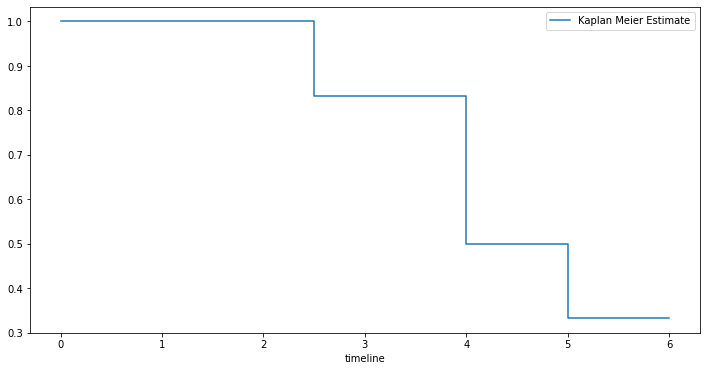

In [4]:
from lifelines import KaplanMeierFitter

## Example Data 
durations = [5,6,6,2.5,4,4]
event_observed = [1, 0, 0, 1, 1, 1]

## create an kmf object
kmf = KaplanMeierFitter() 

## Fit the data into the model
kmf.fit(durations, event_observed,label='Kaplan Meier Estimate')

## Create an estimate
kmf.plot(ci_show=False) ## ci_show is meant for Confidence interval, since our data set is too tiny, thus i am not showing it.

## Real World Example 

### We will be using Telco Customer Churn data from Kaggle
https://www.kaggle.com/blastchar/telco-customer-churn/

In [5]:
##  create a dataframe
df =  pd.read_csv("/content/drive/Shareddrives/캡스톤(COVID-19)/Data_Covid_Death/환자별데이터/latestdata.csv")

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1,2,9,10,12,13,14,15,16,17,19,20,21,22,23,24,25,26,27,31,32) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
## Have a first look at the data
df.head() 

,ID,age,sex,city,province,country,latitude,longitude,geo_resolution,date_onset_symptoms,date_admission_hospital,date_confirmation,symptoms,lives_in_Wuhan,travel_history_dates,travel_history_location,reported_market_exposure,additional_information,chronic_disease_binary,chronic_disease,source,sequence_available,outcome,date_death_or_discharge,notes_for_discussion,location,admin3,admin2,admin1,country_new,admin_id,data_moderator_initials,travel_history_binary
0,000-1-1,NaN,male,Shek Lei,Hong Kong,China,22.365019,114.133808,point,NaN,NaN,14.02.2020,NaN,NaN,22.01.2020,China,NaN,Case 55; mainland China travel via the Lok Ma ...,False,NaN,https://www.scmp.com/news/hong-kong/health-env...,NaN,"critical condition, intubated as of 14.02.2020",NaN,NaN,Shek Lei,NaN,NaN,Hong Kong,China,8029.0,NaN,NaN
1,000-1-10,78,male,Vo Euganeo,Veneto,Italy,45.297748,11.658382,point,NaN,NaN,21.02.2020,NaN,NaN,NaN,NaN,NaN,Hospitalized on 12.02.2020 for other reasons,False,NaN,https://www.corriere.it/cronache/20_febbraio_2...,NaN,death,22.02.2020,NaN,Vo' Euganeo,NaN,NaN,Veneto,Italy,8954.0,NaN,NaN
2,000-1-100,61,female,NaN,NaN,Singapore,1.353460,103.815100,admin0,NaN,NaN,14.02.2020,NaN,NaN,NaN,NaN,NaN,"Case 65; family member of Case 50, a DBS emplo...",False,NaN,https://www.channelnewsasia.com/news/singapore...,NaN,discharge,17.02.2020,NaN,NaN,NaN,NaN,NaN,Singapore,200.0,NaN,NaN
3,000-1-1000,NaN,NaN,Zhengzhou City,Henan,China,34.629310,113.468000,admin2,NaN,NaN,26.01.2020,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,https://news.163.com/special/epidemic/?spssid=...,NaN,NaN,NaN,NaN,NaN,NaN,Zhengzhou City,Henan,China,10091.0,NaN,NaN
4,000-1-10000,NaN,NaN,Pingxiang City,Jiangxi,China,27.513560,113.902900,admin2,NaN,NaN,14.02.2020,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,http://hc.jiangxi.gov.cn/doc/2020/02/15/138898...,NaN,NaN,NaN,NaN,NaN,NaN,Pingxiang City,Jiangxi,China,7060.0,NaN,NaN


In [7]:
## Data Types and Missing Values in Columns
df.info()  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2676311 entries, 0 to 2676310
Data columns (total 33 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   ID                        object 
 1   age                       object 
 2   sex                       object 
 3   city                      object 
 4   province                  object 
 5   country                   object 
 6   latitude                  float64
 7   longitude                 float64
 8   geo_resolution            object 
 9   date_onset_symptoms       object 
 10  date_admission_hospital   object 
 11  date_confirmation         object 
 12  symptoms                  object 
 13  lives_in_Wuhan            object 
 14  travel_history_dates      object 
 15  travel_history_location   object 
 16  reported_market_exposure  object 
 17  additional_information    object 
 18  chronic_disease_binary    bool   
 19  chronic_disease           object 
 20  source                  

In [8]:
filtered = df[['date_confirmation','date_death_or_discharge','outcome','sex']].dropna()
filtered

,date_confirmation,date_death_or_discharge,outcome,sex
1,21.02.2020,22.02.2020,death,male
2,14.02.2020,17.02.2020,discharge,female
113,14.02.2020,20.02.2020,discharge,male
224,14.02.2020,02.03.2020,discharge,female
335,14.02.2020,29.02.2020,discharge,female
...,...,...,...,...
658603,31.01.2020,19.02.2020,recovered,female
658864,03.03.2020,26.02.2020,death,female
661086,01.03.2020,01.03.2020,death,female
670224,18.03.2020,19.03.2020,death,female


In [9]:
filtered["outcome"].value_counts()

died                        803
discharge                   150
discharged                   63
recovered                    53
death                        39
dead                          3
Discharged                    2
released from quarantine      2
Died                          1
Dead                          1
Deceased                      1
Death                         1
Name: outcome, dtype: int64

In [10]:
filtered['outcome']=filtered['outcome'].apply(lambda x: 1 if x == 'died' or x == 'death' or  x == 'dead' or x == 'Deceased' or x == 'Died' or x == 'Death' or x == 'Dead'else 0 )

In [11]:
filtered["outcome"].value_counts()

1    849
0    270
Name: outcome, dtype: int64

In [12]:
d,m,y = filtered.loc[1,['date_confirmation']][0].split('.')

In [13]:
from datetime import datetime

In [14]:
int(d)

21

In [15]:
length = len(filtered)
filtered.index = list(range(length))

In [16]:
filtered

,date_confirmation,date_death_or_discharge,outcome,sex
0,21.02.2020,22.02.2020,1,male
1,14.02.2020,17.02.2020,0,female
2,14.02.2020,20.02.2020,0,male
3,14.02.2020,02.03.2020,0,female
4,14.02.2020,29.02.2020,0,female
...,...,...,...,...
1114,31.01.2020,19.02.2020,0,female
1115,03.03.2020,26.02.2020,1,female
1116,01.03.2020,01.03.2020,1,female
1117,18.03.2020,19.03.2020,1,female


In [22]:
from datetime import datetime

days = []
for idx in range(length):
  conf = filtered.loc[idx,['date_confirmation']][0]
  if '-' in conf:
    a,b,c = conf.split(" - ")[0].split('.')
  else:
    a,b,c = conf.split('.')
  dead = filtered.loc[idx,['date_death_or_discharge']][0]
  if '-' in dead:
    x,y,z = dead.split(" - ")[0].split('.')
  else:
    x,y,z = dead.split('.')

  if int(y) > 12:
    t = x
    x=y
    y=t
  if int(b) > 12:
    t = a
    a=b
    b=t

  death = datetime(int(z),int(y),int(x),0,0,0)
  confirm = datetime(int(c),int(b),int(a),0,0,0)
  days.append((death-confirm).days)


In [23]:
filtered["days"] = days

In [24]:
filtered2 = filtered[filtered["days"]<0]
filtered2

,date_confirmation,date_death_or_discharge,outcome,sex,days
29,04.03.2020,03.03.2020,1,female,-1
33,24.01.2020,17.01.2020,0,male,-7
52,05.02.2020,30.01.2020,0,female,-6
72,06.03.2020,02.03.2020,1,male,-4
74,01.03.2020,26.02.2020,1,male,-4
...,...,...,...,...,...
1111,02.03.2020,01.03.2020,1,female,-1
1112,01.03.2020,29.02.2020,1,male,-1
1113,03.03.2020,26.02.2020,1,male,-6
1115,03.03.2020,26.02.2020,1,female,-6


In [25]:
for idx in range(length):
  d = int(filtered.loc[idx,['days']][0])
  if d < 0:
    conf = filtered.loc[idx,['date_confirmation']][0]
    if '-' in conf:
      a,b,c = conf.split(" - ")[0].split('.')
    else:
      a,b,c = conf.split('.')
    dead = filtered.loc[idx,['date_death_or_discharge']][0]
    if '-' in dead:
      x,y,z = dead.split(" - ")[0].split('.')
    else:
      x,y,z = dead.split('.')

    try:
      death = datetime(int(z),int(x),int(y),0,0,0)
      confirm = datetime(int(c),int(a),int(b),0,0,0)
      filtered.loc[idx,['days']] = -(death-confirm).days
    except:
      filtered.loc[idx,['days']] = None
  else:
    pass


In [26]:
filtered = filtered.dropna()
#이거하고 값하나 사라져서 indexing 다시해야할듯.01.18 석한

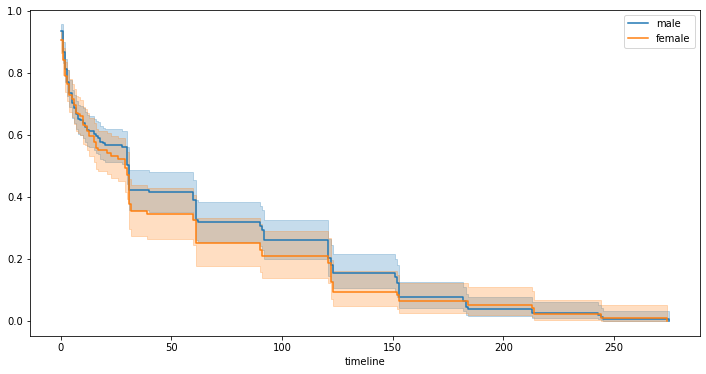

In [28]:
kmf = KaplanMeierFitter() 


T = filtered['days']     ## time to event
E = filtered['outcome']      ## event occurred or censored


groups = filtered['sex']             ## Create the cohorts from the 'Contract' column
ix1 = (groups == 'male')   ## Cohort 1
ix2 = (groups == 'female')         ## Cohort 2


kmf.fit(T[ix1], E[ix1], label='male')    ## fit the cohort 1 data
ax = kmf.plot()


kmf.fit(T[ix2], E[ix2], label='female')         ## fit the cohort 2 data
ax1 = kmf.plot(ax=ax)


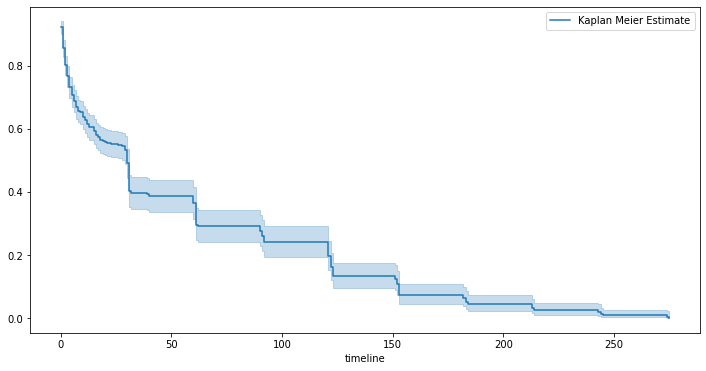

In [27]:
## Lets create an overall KaplanMeier curve, without breaking it into groups of covariates.

## Import the library
from lifelines import KaplanMeierFitter


durations = filtered['days'] ## Time to event data of censored and event data
event_observed = filtered['outcome']  ## It has the churned (1) and censored is (0)

## create a kmf object as km
km = KaplanMeierFitter() ## instantiate the class to create an object

## Fit the data into the model
km.fit(durations, event_observed,label='Kaplan Meier Estimate')

## Create an estimate
km.plot()

## Cox Proportional Hazard Model (Survival Regression)

In [29]:
from lifelines import CoxPHFitter 

In [32]:
## My objective here is to introduce you to the implementation of the model.Thus taking subset of the columns to train the model.
## Only using the subset of the columns present in the original data
df_r= filtered.loc[:,['outcome','sex','days']]
df_r.head() ## have a look at the data 

,outcome,sex,days
0,1,male,1.0
1,0,female,3.0
2,0,male,6.0
3,0,female,17.0
4,0,female,15.0


In [33]:
## Create dummy variables
df_dummy = pd.get_dummies(df_r, drop_first=True)
df_dummy.head()

,outcome,days,sex_male
0,1,1.0,1
1,0,3.0,0
2,0,6.0,1
3,0,17.0,0
4,0,15.0,0


In [34]:
# Using Cox Proportional Hazards model
cph = CoxPHFitter()   ## Instantiate the class to create a cph object
cph.fit(df_dummy, 'days', event_col='outcome')   ## Fit the data to train the model
cph.print_summary()    ## HAve a look at the significance of the features

<lifelines.CoxPHFitter: fitted with 677 total observations, 266 right-censored observations>
             duration col = 'days'
                event col = 'outcome'
      baseline estimation = breslow
   number of observations = 677
number of events observed = 411
   partial log-likelihood = -2233.60
         time fit was run = 2021-01-15 02:58:44 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
sex_male   -0.08       0.92       0.10            -0.28             0.12                 0.76                 1.12

              z    p   -log2(p)
covariate                      
sex_male  -0.80 0.42       1.24
---
Concordance = 0.51
Partial AIC = 4469.20
log-likelihood ratio test = 0.63 on 1 df
-log2(p) of ll-ratio test = 1.23

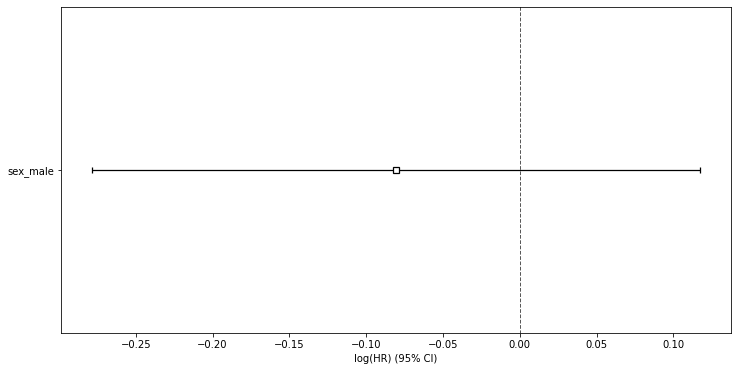

In [35]:
cph.plot()

In [40]:
tr_rows = df_dummy.iloc[15:17, 2:]
tr_rows

,sex_male
15,1
16,0


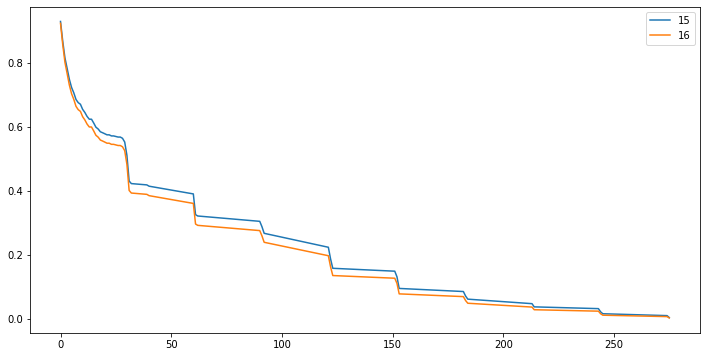

In [41]:
cph.predict_survival_function(tr_rows).plot()

In [ ]:
## Convert TotalCharges to numeric
df['TotalCharges']=pd.to_numeric(df['TotalCharges'],errors='coerce')

## Replace yes and No in the Churn column to 1 and 0. 1 for the event and 0 for the censured data.
df['Churn']=df['Churn'].apply(lambda x: 1 if x == 'Yes' else 0 )

In [ ]:
## after converting the column TotalCharges to numeric
df.info()  ## Column TotalCharges is having missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
customerID          7043 non-null object
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
tenure              7043 non-null int64
PhoneService        7043 non-null object
MultipleLines       7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
Contract            7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7032 non-null float64
Churn               7043 non-null int64
dtypes: float64(2), int64(3), obj

In [ ]:
## Impute the null value with the median value

df.TotalCharges.fillna(value=df['TotalCharges'].median(),inplace=True)

In [ ]:
## Create a list of Categorical Columns
cat_cols= [i  for i in df.columns if df[i].dtype==object]
cat_cols.remove('customerID')  ## customerID has been removed because it is unique for all the rows.

In [ ]:
## lets have a look at the categories and their distribution in all the categorical columns.

for i in cat_cols:
    print('Column Name: ',i)
    print(df[i].value_counts())
    print('-----------------------------')

Column Name:  gender
Male      3555
Female    3488
Name: gender, dtype: int64
-----------------------------
Column Name:  Partner
No     3641
Yes    3402
Name: Partner, dtype: int64
-----------------------------
Column Name:  Dependents
No     4933
Yes    2110
Name: Dependents, dtype: int64
-----------------------------
Column Name:  PhoneService
Yes    6361
No      682
Name: PhoneService, dtype: int64
-----------------------------
Column Name:  MultipleLines
No                  3390
Yes                 2971
No phone service     682
Name: MultipleLines, dtype: int64
-----------------------------
Column Name:  InternetService
Fiber optic    3096
DSL            2421
No             1526
Name: InternetService, dtype: int64
-----------------------------
Column Name:  OnlineSecurity
No                     3498
Yes                    2019
No internet service    1526
Name: OnlineSecurity, dtype: int64
-----------------------------
Column Name:  OnlineBackup
No                     3088
Yes     

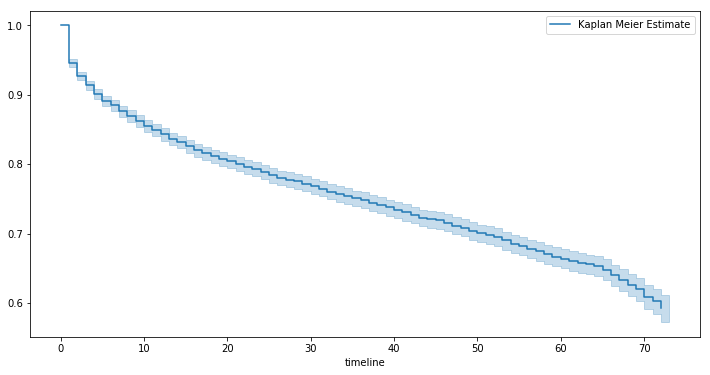

In [ ]:
## Lets create an overall KaplanMeier curve, without breaking it into groups of covariates.

## Import the library
from lifelines import KaplanMeierFitter


durations = df['tenure'] ## Time to event data of censored and event data
event_observed = df['Churn']  ## It has the churned (1) and censored is (0)

## create a kmf object as km
km = KaplanMeierFitter() ## instantiate the class to create an object

## Fit the data into the model
km.fit(durations, event_observed,label='Kaplan Meier Estimate')

## Create an estimate
km.plot()

## Lets create Kaplan Meier Curves for Cohorts

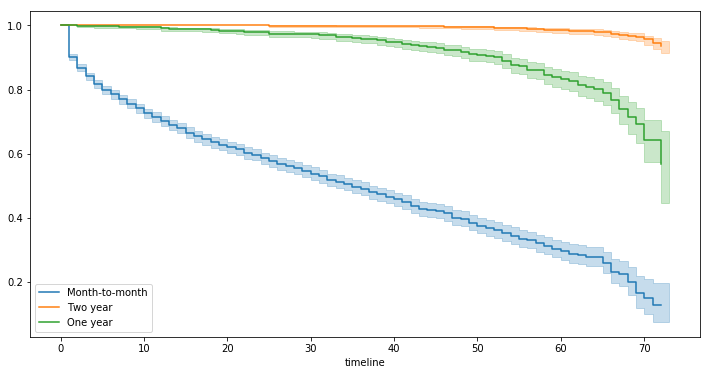

In [ ]:
kmf = KaplanMeierFitter() 


T = df['tenure']     ## time to event
E = df['Churn']      ## event occurred or censored


groups = df['Contract']             ## Create the cohorts from the 'Contract' column
ix1 = (groups == 'Month-to-month')   ## Cohort 1
ix2 = (groups == 'Two year')         ## Cohort 2
ix3 = (groups == 'One year')         ## Cohort 3


kmf.fit(T[ix1], E[ix1], label='Month-to-month')    ## fit the cohort 1 data
ax = kmf.plot()


kmf.fit(T[ix2], E[ix2], label='Two year')         ## fit the cohort 2 data
ax1 = kmf.plot(ax=ax)


kmf.fit(T[ix3], E[ix3], label='One year')        ## fit the cohort 3 data
kmf.plot(ax=ax1)                                 ## Plot the KM curve for three cohort on same x and y axis

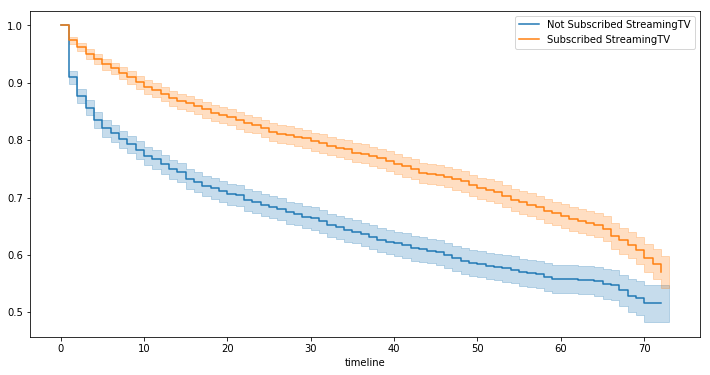

In [ ]:
kmf1 = KaplanMeierFitter() ## instantiate the class to create an object

## Two Cohorts are compared. 1. Streaming TV Not Subsribed by Users, 2. Streaming TV subscribed by the users.
groups = df['StreamingTV']   
i1 = (groups == 'No')      ## group i1 , having the pandas series for the 1st cohort
i2 = (groups == 'Yes')     ## group i2 , having the pandas series for the 2nd cohort


## fit the model for 1st cohort
kmf1.fit(T[i1], E[i1], label='Not Subscribed StreamingTV')
a1 = kmf1.plot()

## fit the model for 2nd cohort
kmf1.fit(T[i2], E[i2], label='Subscribed StreamingTV')
kmf1.plot(ax=a1)

## Cox Proportional Hazard Model (Survival Regression)

In [ ]:
from lifelines import CoxPHFitter     

In [ ]:
## My objective here is to introduce you to the implementation of the model.Thus taking subset of the columns to train the model.
## Only using the subset of the columns present in the original data
df_r= df.loc[:,['tenure','Churn','gender','Partner','Dependents','PhoneService','MonthlyCharges','SeniorCitizen','StreamingTV']]
df_r.head() ## have a look at the data 

,tenure,Churn,gender,Partner,Dependents,PhoneService,MonthlyCharges,SeniorCitizen,StreamingTV
0,1,0,Female,Yes,No,No,29.85,0,No
1,34,0,Male,No,No,Yes,56.95,0,No
2,2,1,Male,No,No,Yes,53.85,0,No
3,45,0,Male,No,No,No,42.30,0,No
4,2,1,Female,No,No,Yes,70.70,0,No


In [ ]:
## Create dummy variables
df_dummy = pd.get_dummies(df_r, drop_first=True)
df_dummy.head()

,tenure,Churn,MonthlyCharges,SeniorCitizen,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,StreamingTV_No internet service,StreamingTV_Yes
0,1,0,29.85,0,0,1,0,0,0,0
1,34,0,56.95,0,1,0,0,1,0,0
2,2,1,53.85,0,1,0,0,1,0,0
3,45,0,42.30,0,1,0,0,0,0,0
4,2,1,70.70,0,0,0,0,1,0,0


In [ ]:
# Using Cox Proportional Hazards model
cph = CoxPHFitter()   ## Instantiate the class to create a cph object
cph.fit(df_dummy, 'tenure', event_col='Churn')   ## Fit the data to train the model
cph.print_summary()    ## HAve a look at the significance of the features

<lifelines.CoxPHFitter: fitted with 7043 observations, 5174 censored>
      duration col = tenure
         event col = Churn
number of subjects = 7043
  number of events = 1869
    log-likelihood = -15182.388
  time fit was run = 2019-01-06 06:00:01 UTC

---
                                   coef  exp(coef)  se(coef)        z      p  lower 0.95  upper 0.95     
MonthlyCharges                  -0.0109     0.9892    0.0018  -6.1274 0.0000     -0.0143     -0.0074  ***
SeniorCitizen                    0.3964     1.4864    0.0554   7.1581 0.0000      0.2878      0.5049  ***
gender_Male                     -0.0107     0.9894    0.0463  -0.2311 0.8173     -0.1015      0.0801     
Partner_Yes                     -0.8091     0.4452    0.0542 -14.9282 0.0000     -0.9154     -0.7029  ***
Dependents_Yes                  -0.3559     0.7006    0.0682  -5.2149 0.0000     -0.4896     -0.2221  ***
PhoneService_Yes                 0.6914     1.9964    0.1040   6.6472 0.0000      0.4875      0.8952  ***

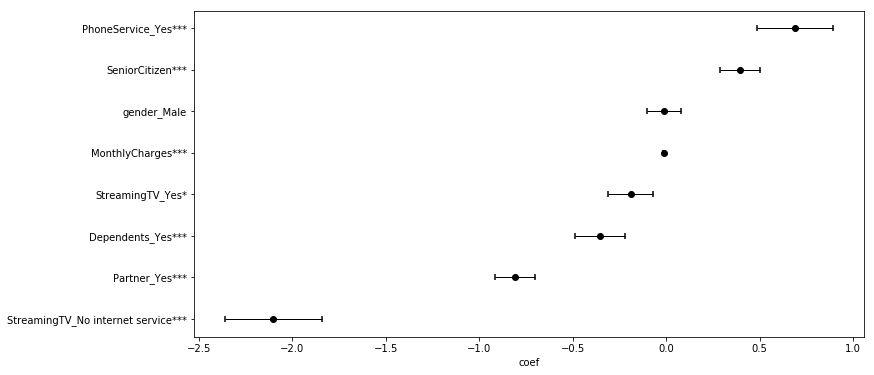

In [ ]:
cph.plot()

In [ ]:
## Check all the methods and attributes associated with the cph object.
dir(cph)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_check_values',
 '_compute_baseline_cumulative_hazard',
 '_compute_baseline_hazard',
 '_compute_baseline_hazards',
 '_compute_baseline_survival',
 '_compute_confidence_intervals',
 '_compute_delta_beta',
 '_compute_likelihood_ratio_test',
 '_compute_p_values',
 '_compute_residuals_within_strata',
 '_compute_sandwich_estimator',
 '_compute_standard_errors',
 '_compute_z_values',
 '_concordance_score_',
 '_get_efron_values',
 '_hessian_',
 '_log_likelihood',
 '_n_examples',
 '_newton_rhaphson',
 '_norm_mean',
 '_norm_std',
 '_score_',
 '_time_fit_was_called',
 '_train_log_partial_hazard',
 'alpha',
 'baseline_cumulative_ha

In [ ]:
## We want to see the Survival curve at the customer level. Therefore, we have selected 6 customers (rows 5 till 9).

tr_rows = df_dummy.iloc[5:10, 2:]
tr_rows

,MonthlyCharges,SeniorCitizen,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,StreamingTV_No internet service,StreamingTV_Yes
5,99.65,0,0,0,0,1,0,1
6,89.10,0,1,0,1,1,0,1
7,29.75,0,0,0,0,0,0,0
8,104.80,0,0,1,0,1,0,1
9,56.15,0,1,0,1,1,0,0


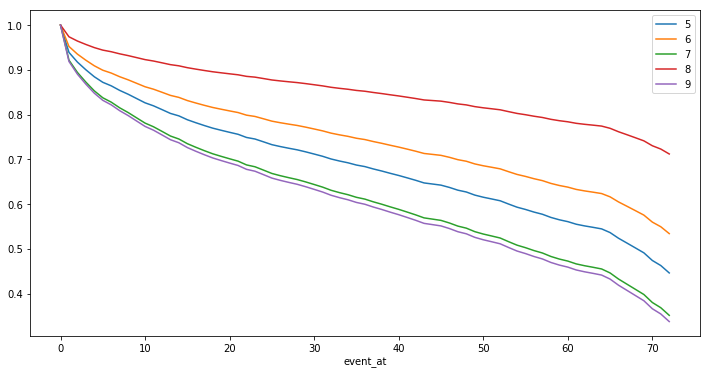

In [ ]:
## Lets predict the survival curve for the selected customers. 
## Customers can be identified with the help of the number mentioned against each curve.
cph.predict_survival_function(tr_rows).plot()